$$\mathbf{t = Xw + \epsilon}$$

In [1]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from io import StringIO

male_100m = StringIO(r"""
1896,12
1900,11
1904,11
1906,11.2
1908,10.8
1912,10.8
1920,10.8
1924,10.6
1928,10.8
1932,10.3
1936,10.3
1948,10.3
1952,10.4
1956,10.5
1960,10.2
1964,10
1968,9.95
1972,10.14
1976,10.06
1980,10.25
1984,9.99
1988,9.92
1992,9.96
1996,9.84
2000,9.87
2004,9.85
2008,9.69
2012,9.63
"""
)

data = pd.read_csv(male_100m, index_col=0, header=None)
data.columns = ['time_s']
data.index.name = "year"

Likelihood:

$$p(\mathbf{t|w,X},\sigma^2) = \mathcal{N}(\mathbf{Xw},\sigma^2\mathbf{I_N})$$

We want to choose a prior that is conjugate to a Gaussian likelihood - therefore a Gaussian prior.

$$p(\mathbf{w|\mu_0, \Sigma_0)}) = \mathcal{N}(\mathbf{\mu_0, \Sigma_0})$$

Note that $\mathbf{\mu_0}$ and $\mathbf{\Sigma_0}$ are vectors themselves. We will choose these parameters later.

Posterior: We know it will be Gaussian. From Bayes, the marginal likelihood is just a scaling factor. We don't know what this is, but don't bother, because we know that the posterior is Gaussian, munge the rest of it until it looks like a Gaussian. 

$$p(\mathbf{w|t,X},\sigma^2) \propto p(\mathbf{t|w,X},\sigma^2) p(\mathbf{w|\mu_0, \Sigma_0})$$
$$...$$
$$p(\mathbf{w|t,X},\sigma^2) \propto exp \Bigg\{ -\frac{1}{2} \Bigg( -\frac{2}{\sigma^2} \mathbf{t^TXw} + \frac{1}{\sigma^2}\mathbf{w^TX^Tw + w^T\Sigma_0^{-1}w} - 2 \mathbf{\mu_0^T \Sigma_0^{-1}w}  \Bigg) \Bigg\}$$

If we know that the posterior is Gaussian, remove all the constants and munge the rest into something that looks like a Gaussian

$$p(\mathbf{w|t,X},\sigma^2) \propto \mathcal{N}(\mathbf{\mu_w, \Sigma_w})$$
$$p(\mathbf{w|t,X},\sigma^2) \propto exp \Bigg(-\frac{1}{2}\mathbf{(w-\mu_w)^T\Sigma^{-1}_w(w-\mu_w)} \Bigg)$$

Compare with an earlier equation found for the posterior

$$p(\mathbf{w|t,X},\sigma^2) \propto exp \Bigg\{-\frac{1}{2}\Bigg(\frac{1}{\sigma^2}(\mathbf{t-Xw})^T(\mathbf{t-Xw}) + (\mathbf{w-\mu_0})^T\mathbf{\Sigma_0^{-1}}(\mathbf{w-\mu_0}) \Bigg) \Bigg\}$$

Equate the terms with the same degree and we get

$$\mathbf{\Sigma_w} = \Bigg(\frac{1}{\sigma^2}\mathbf{X^TX + \Sigma_0^{-1}} \Bigg)^{-1}$$

$$\mathbf{\mu_w} = \mathbf{\Sigma_w} \Bigg(\frac{1}{\sigma_2}\mathbf{X^Tt + \Sigma_0^{-1}\mu_0} \Bigg) $$

Notice if $\Sigma_0$ is 0, these reduce to the standard linear regression terms. 

## Analysis of Olympic dataset with Bayesian treatment

Choose prior parameters $\mathbf{\mu_0}$ and $\mathbf{\Sigma_0}$.

A conventional choice is $\mathbf{\mu_0} = [0, 0]^T$

For covariance choose

$$\mathbf{\Sigma_0} = 
\begin{bmatrix}
100& 0\\
0& 5
\end{bmatrix}
$$

The above means that we think $w_0$ a greater variance than $w_1$, and that $w_0$ and $w_0$ are independent (the off-diagonal elements are zero). 

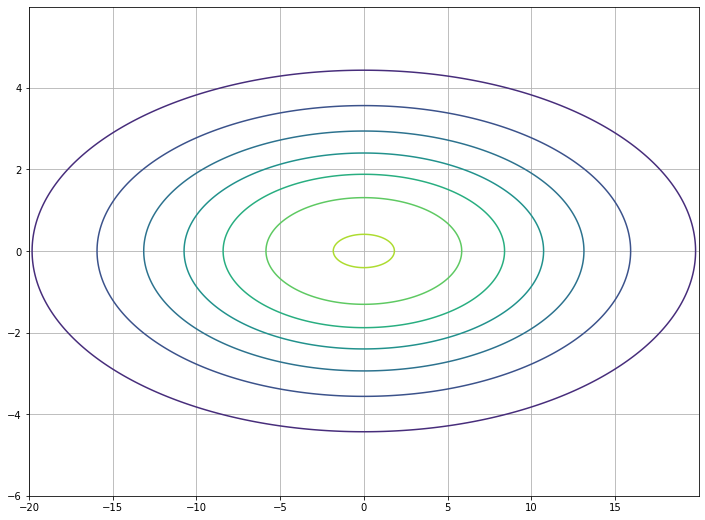

In [2]:
import numpy as np
from scipy.stats import multivariate_normal

w0, w1 = np.mgrid[-20:20:0.01, -6:6:0.01]
pos = np.empty(w0.shape + (2,))
pos[:, :, 0] = w0
pos[:, :, 1] = w1

mu0 = [0, 0]
sigma0 = [[100, 0], [0, 5]]

rv = multivariate_normal(mu0, sigma0)

fig, ax = plt.subplots(figsize=(12, 9))
CS = ax.contour(w0, w1, rv.pdf(pos))
plt.grid()

Sample various $w_0$ and $w_1$ from this model and see what kind of results we get for $t_n = w_0 + w_1x_n$

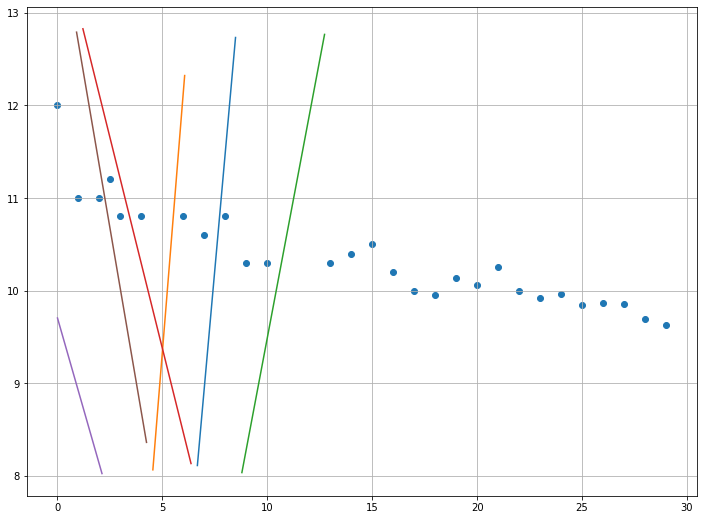

In [3]:
# rescale the data.

normalised_index = (data.index - 1896 )/4
data_ = data.copy()
data_.index = normalised_index

plt.figure(figsize=(12,9))
plt.scatter(data_.index, data_.values)
plt.grid()

npos = 4
nneg = 4
while npos > 0 or nneg > 0:
    # keep sampling until we get a w0, w1 in the right region.
    # we want points whose y is in 9-12 and whose x is in 0-30
    x = np.linspace(0, 30, num=100)
    w0, w1 = rv.rvs(1)
    y = w0 + w1*x
    select = (y>8) & (y<13)
    yrem = y[select]
    if yrem.size < 5:
        continue
    if w1 > 0:
        npos -= 1
    else:
        nneg -= 1
    if npos > 0 and w1 > 0:
        plt.plot(x[select], yrem)
    if nneg > 0 and w1 < 0:
        plt.plot(x[select], yrem)

Now observe each data point and compute the posterior distribution. 

Recall:

$$p(\mathbf{w|t, X}) = \mathcal{N}(\mu_w, \Sigma_w)$$

$$\mathbf{\Sigma_w} = \Bigg(\frac{1}{\sigma^2}\mathbf{X^TX + \Sigma_0^{-1}} \Bigg)^{-1}$$

$$\mathbf{\mu_w} = \mathbf{\Sigma_w} \Bigg(\frac{1}{\sigma_2}\mathbf{X^Tt + \Sigma_0^{-1}\mu_0} \Bigg) $$

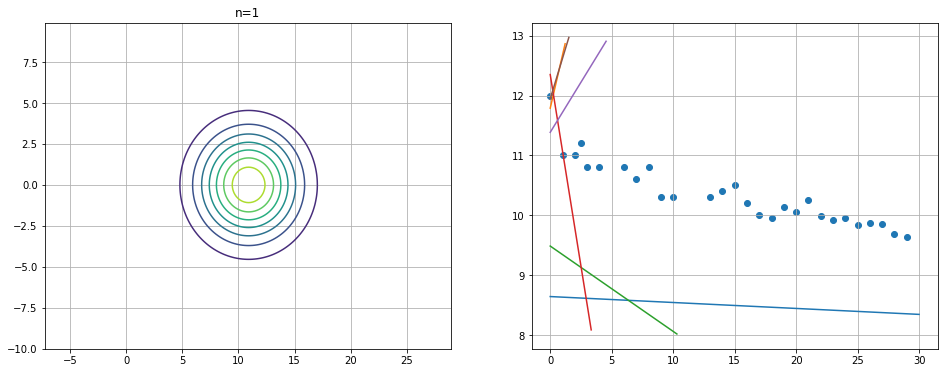

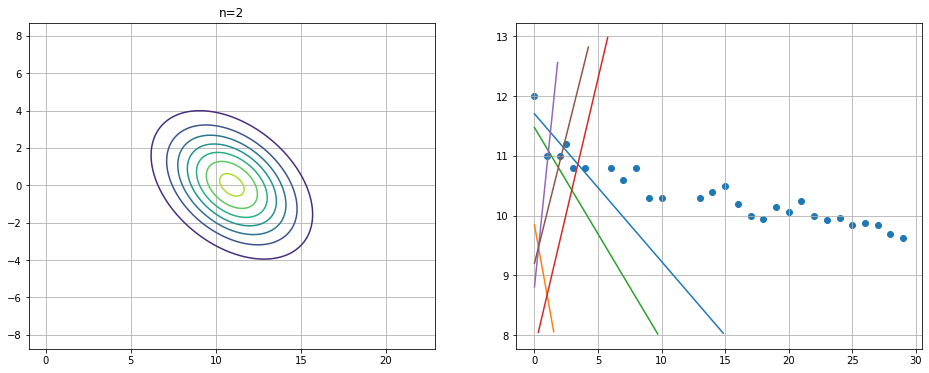

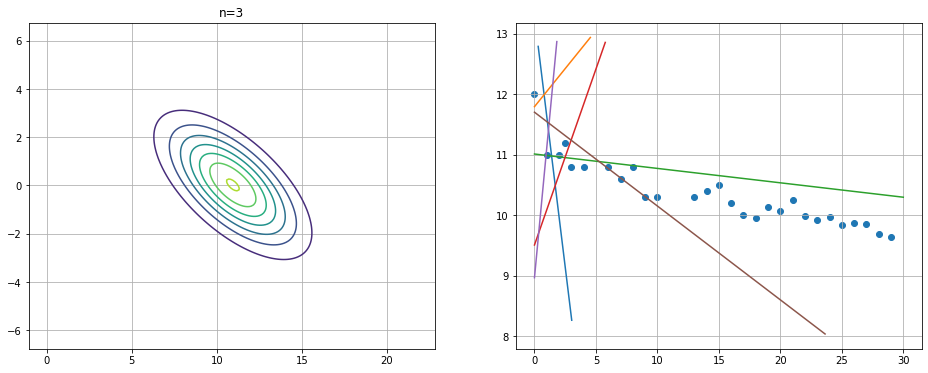

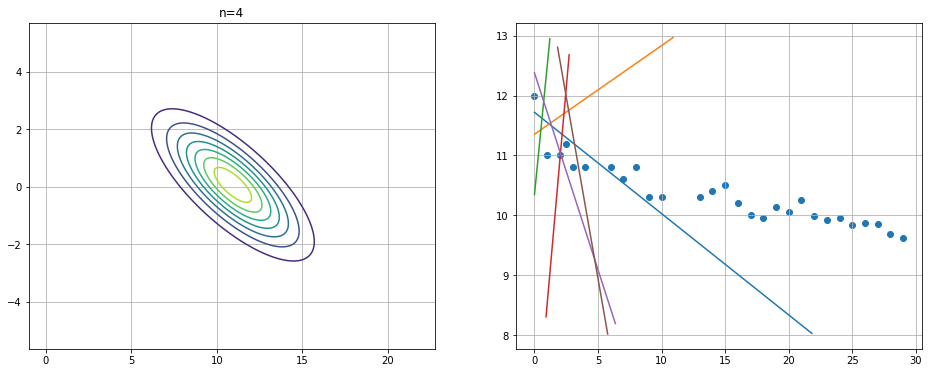

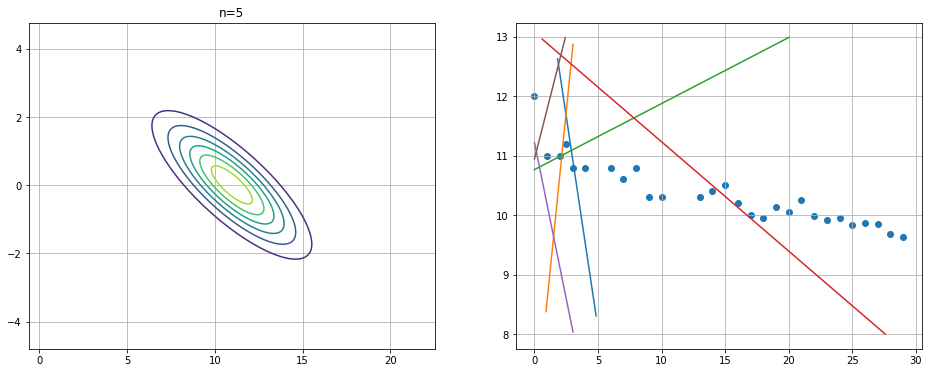

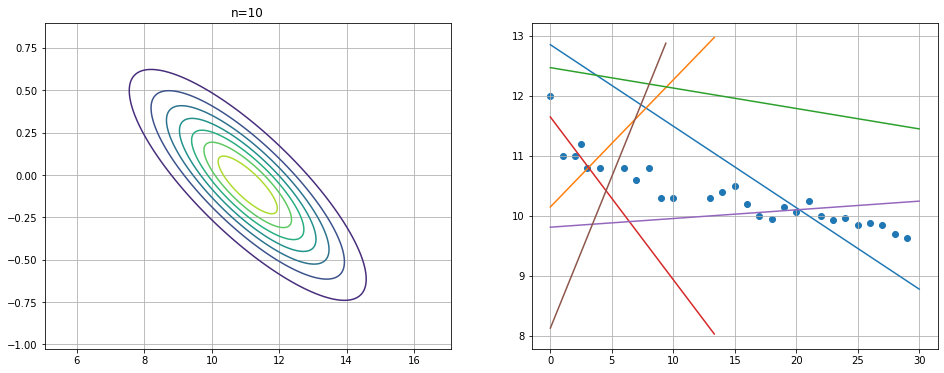

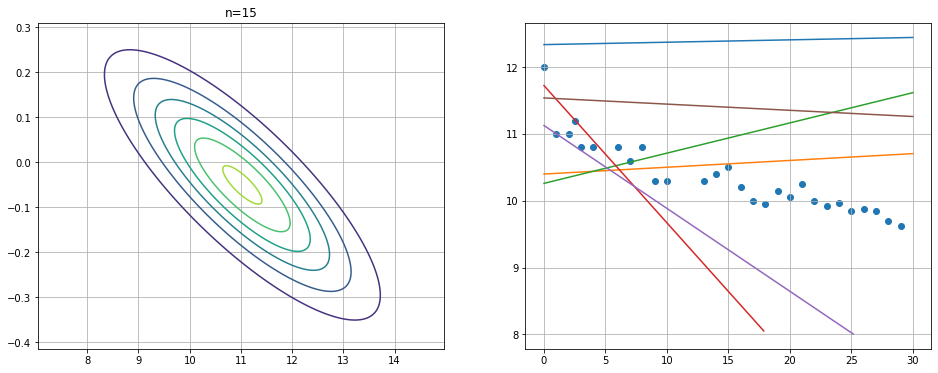

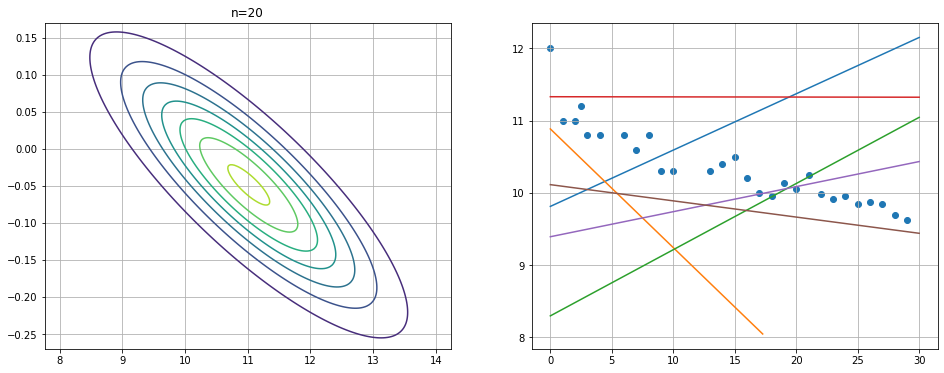

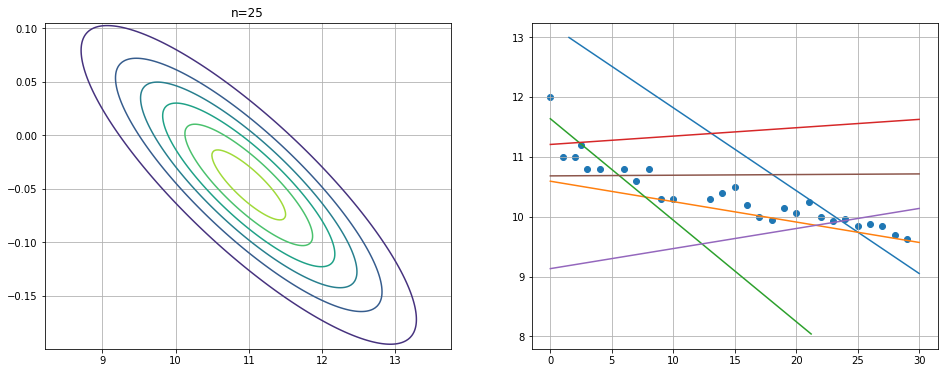

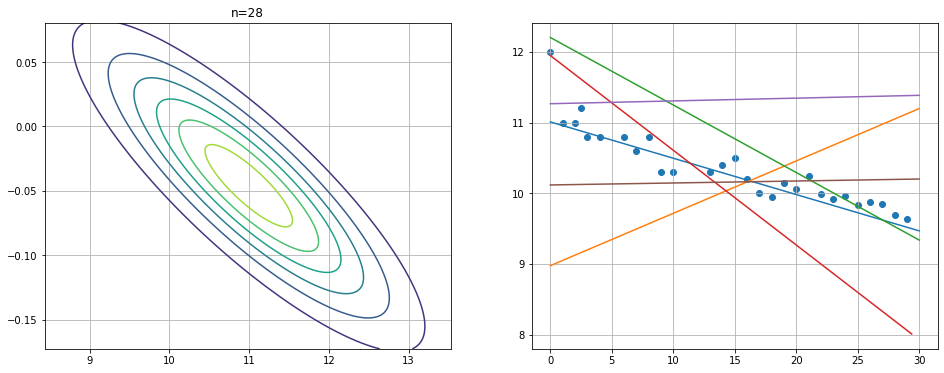

In [4]:
s2 = 10   # given


pinv = np.linalg.pinv

def update_params(data, n, sigma=s2):
    # given the data, and an index n exclusive, 
    # calculate X, t and update mu_w and sigma_w
    X = np.vstack([np.ones(n), data.index.values[:n]]).T
    t = data.values.squeeze()[:n]
    sigma_inv = pinv(sigma0)
    sigma_w_inv = np.einsum('ij,jk->ik', X.T, X)/sigma +  sigma_inv
    sigma_w = pinv(sigma_w_inv)
    mu_w = np.dot(sigma_w, np.einsum('ij,j->i', X.T, t)/sigma + np.dot(sigma_inv, mu0))
    return mu_w, sigma_w

def plot_gaussian(mu, sigma, title, ax, colors=None):
    mu0, mu1 = mu
    w0lim = np.sqrt(np.dot(sigma[0], sigma[0])) * 2 
    w0step = w0lim/100
    w0slice = slice(-w0lim + mu0, w0lim + mu0, w0step)
    w1lim = np.sqrt(np.dot(sigma[1], sigma[1])) * 2
    w1step = w1lim/100
    w1slice = slice(-w1lim + mu1, w1lim + mu1, w1step)
    #w0, w1 = np.mgrid[-20:20:0.01, -6:6:0.01]
    w0, w1 = np.mgrid[w0slice, w1slice]
    pos = np.empty(w0.shape + (2,))
    pos[:, :, 0] = w0
    pos[:, :, 1] = w1

    rv = multivariate_normal(mu, sigma)

    #lt.subplot(1, 2, 1)#figsize=(12, 9))
    kwargs = {}
    if colors is not None:
        kwargs['colors'] = colors
    CS = ax.contour(w0, w1, rv.pdf(pos), **kwargs)
    ax.grid()
    ax.set_title(f"{title}")#": w0slice={w0slice}, w1slice={w1slice}")
    return rv

def plot_samples(rv, ax, selective=True):
    # select=True will choose samples that look nice
    #plt.subplot(1, 2, 2)
    ax.scatter(data_.index, data_.values)
    ax.grid()

    npos = 4
    nneg = 4
    while npos > 0 or nneg > 0:
        # keep sampling until we get a w0, w1 in the right region.
        # we want points whose y is in 9-12 and whose x is in 0-30
        x = np.linspace(0, 30, num=100)
        w0, w1 = rv.rvs(1)
        y = w0 + w1*x
        if selective:
            select = (y>8) & (y<13)
            yrem = y[select]
            if yrem.size < 5:
                continue
            if w1 > 0:
                npos -= 1
            else:
                nneg -= 1

            if npos > 0 and w1 > 0:
                ax.plot(x[select], yrem)
            if nneg > 0 and w1 < 0:
                ax.plot(x[select], yrem)
        else:
            npos -= 1
            nneg -= 1
            ax.plot(x, y)

for n in [1, 2, 3, 4, 5, 10, 15, 20, 25, 28]:
            
    figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    mu_w, sigma_w = update_params(data_, n)

    rv = plot_gaussian(mu_w, sigma_w, f'n={n}', axes[0])
    plot_samples(rv, axes[1])


Repeat for $\sigma^2 = 0.05$

n=1
n=2
n=3
n=4
n=5
n=6
n=7
n=8
n=9
n=10
n=15
n=20
n=25
n=28


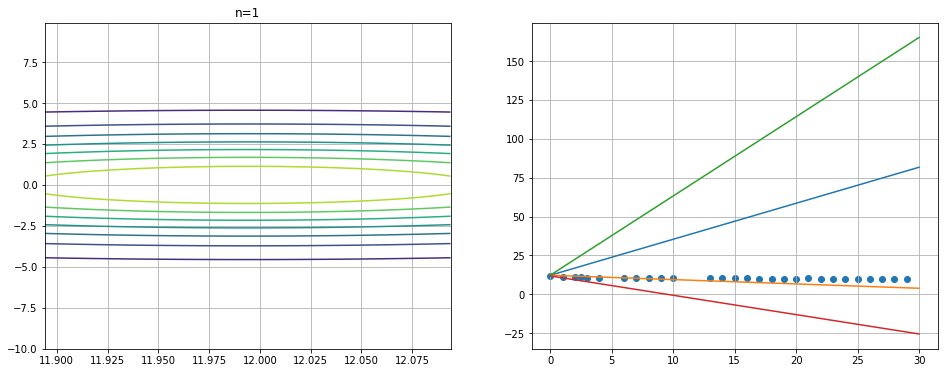

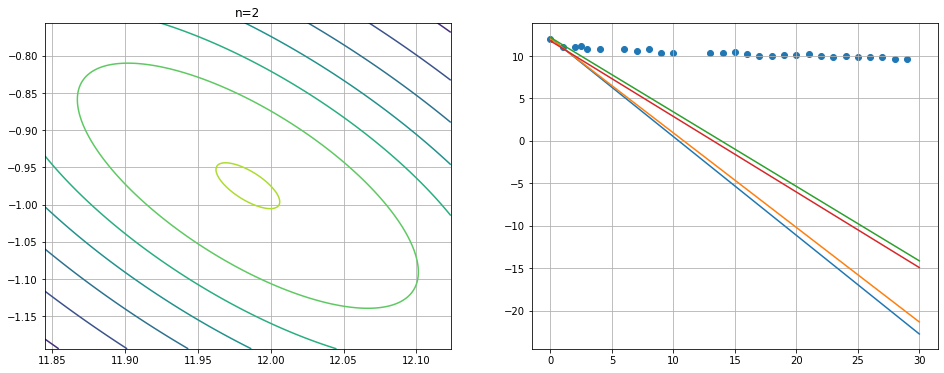

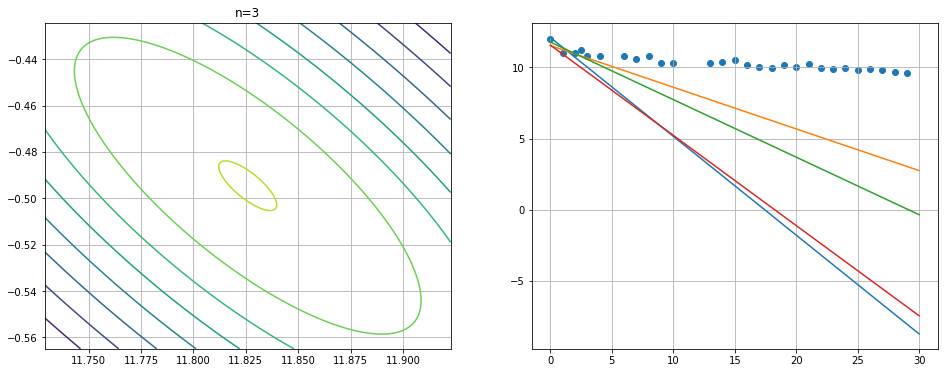

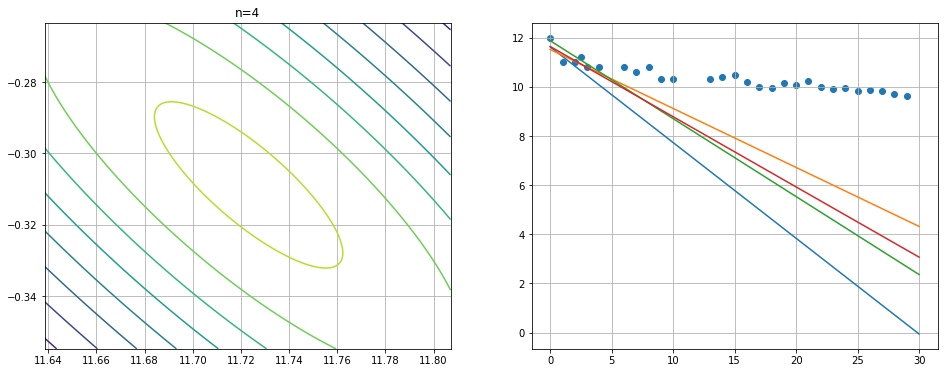

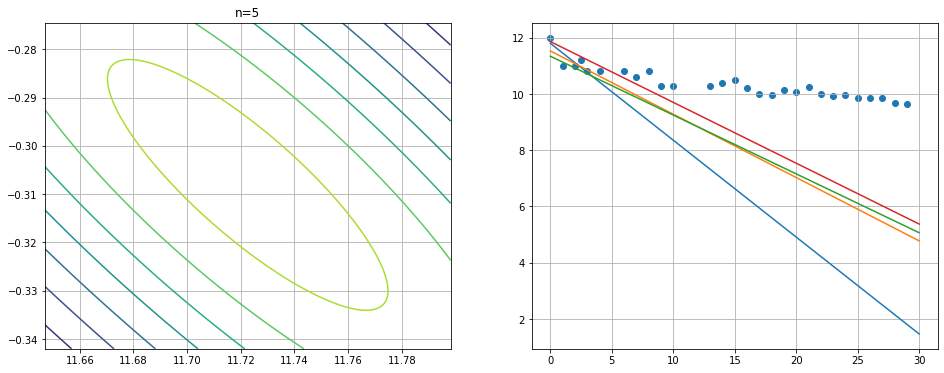

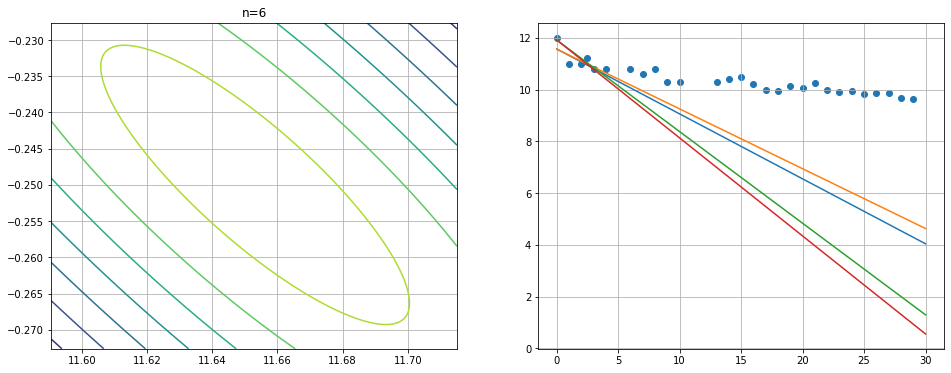

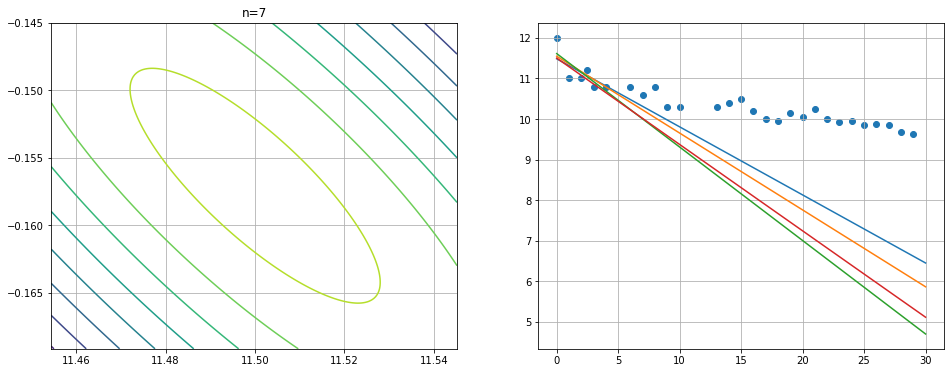

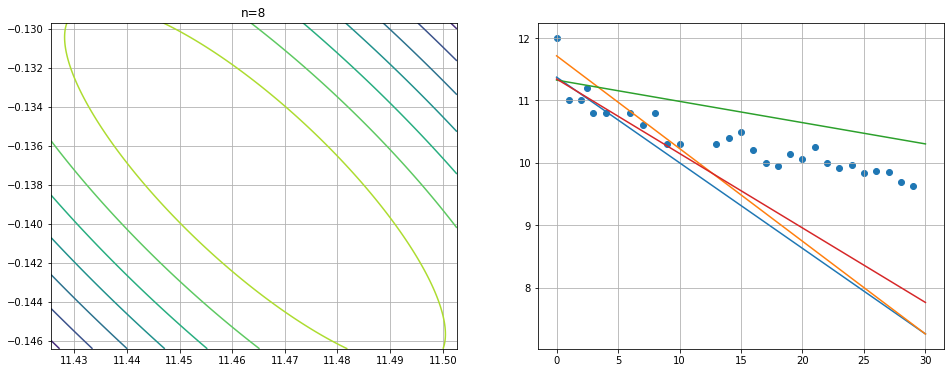

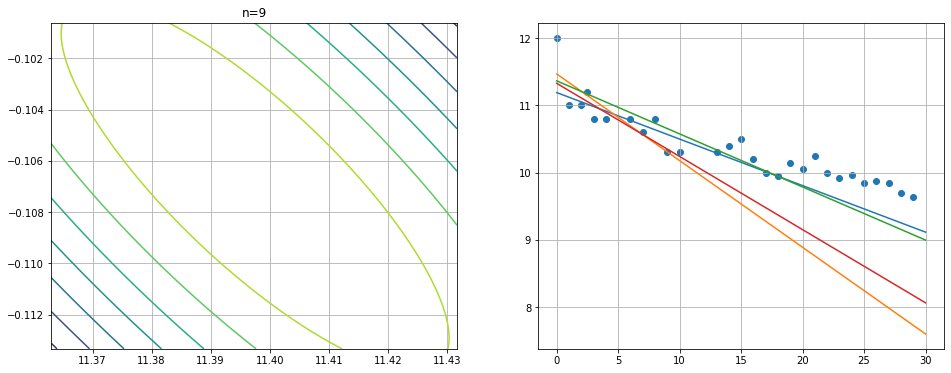

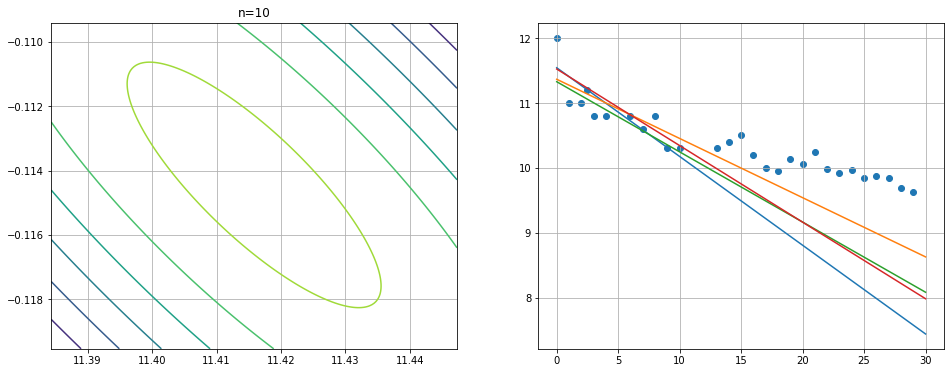

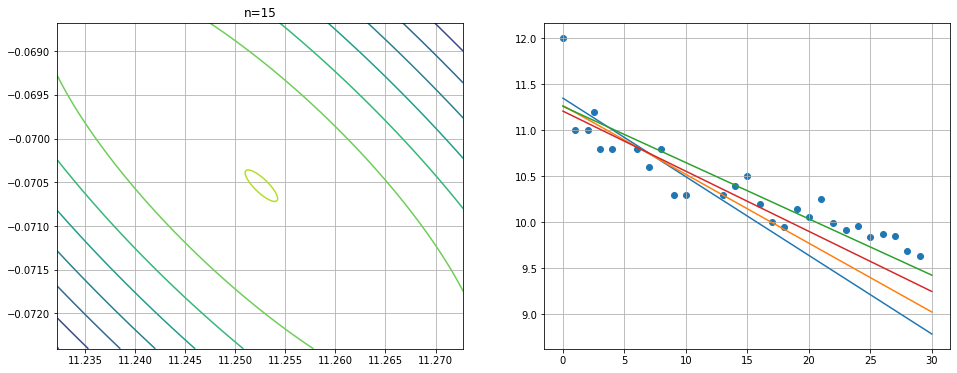

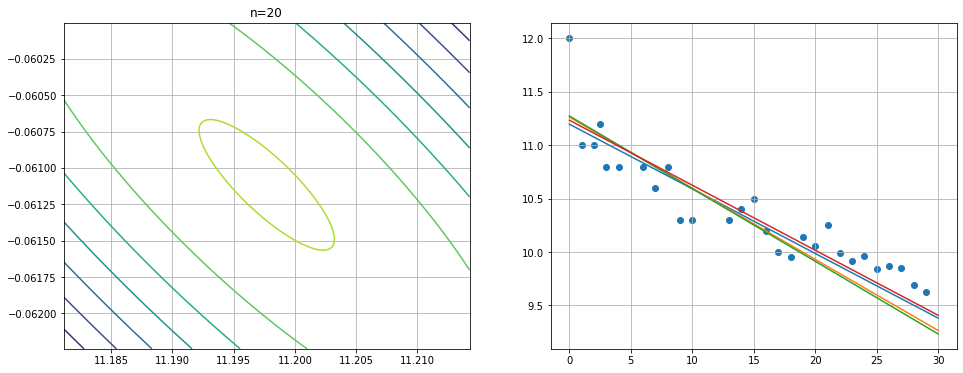

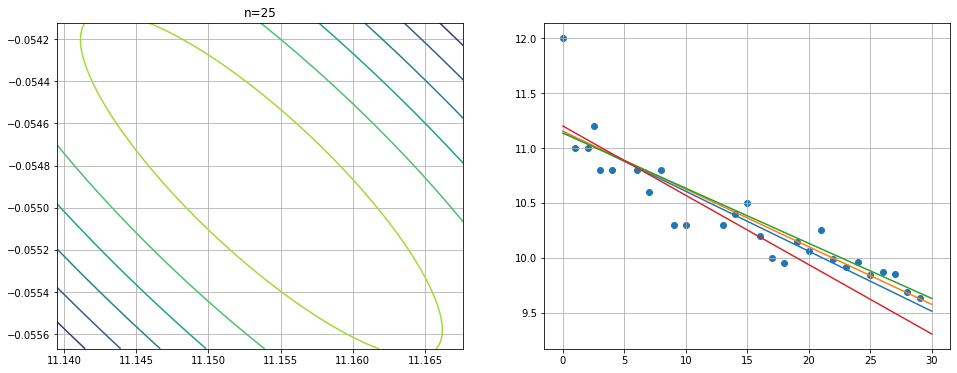

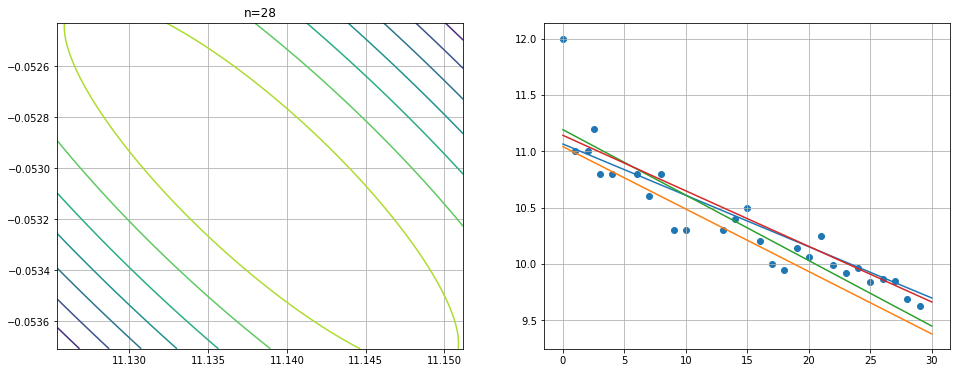

In [5]:
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 28]:
#for n in range(1, 29):
    print(f"n={n}")
    figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    mu_w, sigma_w = update_params(data_, n, sigma=0.05)

    rv = plot_gaussian(mu_w, sigma_w, f'n={n}', axes[0])
    plot_samples(rv, axes[1], selective=False)


## Predictions

When we have a new observation $\mathbf{x}_{new}$ we want to find $p(t_{new} | \mathbf{x_{new}, X, t}, \sigma^2)$

There is no $\mathbf{w}$ in this expression. 

We have an expression for the posterior: $p(\mathbf{w|t, X}, \sigma^2)$. We need to take an expectation wrt this- to integrate out $\mathbf{w}$

$$p(t_{new} | \mathbf{x_{new}, X, t}, \sigma^2) = \mathbf{E_{p(w|t,X,\sigma^2)} \big\{ p(t_{new}|\mathbf{x_{new}, w, \sigma^2} ) \big\}}$$

$$p(t_{new} | \mathbf{x_{new}, X, t}, \sigma^2) = \displaystyle\int p(t_{new}|\mathbf{x_{new}, w, \sigma^2}) p(\mathbf{w|t,X},\sigma^2) d\mathbf{w} $$

$p(t_{new}|\mathbf{x_{new}, w,} \sigma^2)$  is the output of our model and follows a distribution $\mathcal{N}(\mathbf{x^T_{new}w}, \sigma^2)$ - note that this is __univariate Gaussian__

$p(\mathbf{w|\mu, \Sigma})= \mathcal{N}(\mathbf{\mu, \Sigma})$ 

I don't know how to get the next equation:



$$p(t_{new} | \mathbf{x_{new}, X, t}, \sigma^2) = \displaystyle\int p(t_{new}|\mathbf{x_{new}, w, \sigma^2}) p(\mathbf{w|t,X},\sigma^2) d\mathbf{w} $$

$$p(t_{new} | \mathbf{x_{new}, X, t}, \sigma^2) = \displaystyle\int \mathcal{N}(\mathbf{x^T_{new}w}, \sigma^2) p(\mathbf{w|t,X},\sigma^2) d\mathbf{w} $$

$$p(t_{new}|\mathbf{x_{new}, X, t}, \sigma^2) = \mathcal{N}(\mathbf{x^T_{new}\mu_w},\sigma^2 + \mathbf{x^T_{new}\Sigma_wx_{new}})$$
 
$\mu_w$, $\Sigma_w$ are the values after training with all the data

In [42]:
mu_w

array([11.13838222, -0.05306538])

In [43]:
sigma_w

array([[ 6.47110623e-03, -3.20376581e-04],
       [-3.20376581e-04,  2.19064822e-05]])

In [41]:
from scipy.stats import norm

def predict(xnew, mu, sigma, s2):
    # mu: training mu_w
    # sigma: training sigma_w
    # s2: sigma-squared, given
    # xnew: new point
    mean = np.dot(xnew, mu)
    # note no output for einsum, means collapse it all to one number
    var = s2 + np.einsum('i,ij,j', xnew, sigma, xnew)
    rv = norm(loc=mean, scale=np.sqrt(var))
    return rv


In [44]:
# predict a distribution for 2016

scaled = (2016 - 1896 )/4
xnew = np.array([1, scaled])

In [39]:
out = predict(xnew, mu_w, sigma_w, s2=0.05)

In [47]:
out.mean()

9.546420951294781

In [48]:
out.var()

0.05696434534252581

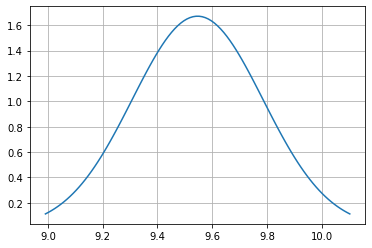

In [49]:
x = np.linspace(out.ppf(0.01), out.ppf(0.99), num=100)
plt.plot(x, out.pdf(x))
plt.grid()

We don't get a single value, we get a distribution which gives us the uncertainty of the output. 